In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import json
import pandas as pd
# Load JSON data from a file into a dictionary
df = pd.read_csv("results/csv/vnexpress_thegioi_24_6.csv")
df = df.fillna("")
# Display the dictionary

In [20]:
data = df.to_dict('records')

In [ ]:
from backend.extractor.task.llm_downstream_utils import get_summarize_prompt, llm_get_tags

# Word Cloud

In [21]:
data

[{'title': 'Hơn 50 người Ấn Độ chết vì ngộ độc rượu',
  'description': 'Giới chức bang Tamil Nadu ở miền nam Ấn Độ thông báo 53 người chết vì uống rượu pha cồn công nghiệp methanol, một loại chất độc.',
  'article': 'Vụ ngộ độc xảy ra ngày 18/6 khiến hơn 100 người phải nhập viện, song nhiều nạn nhân trong tình trạng nguy kịch đến mức các bác sĩ không thể cứu chữa. Muthuvel Stalin, thủ hiến bang Tamil Nadu, cho biết 37 người thiệt mạng vài giờ sau khi uống rượu pha cồn công nghiệp methanol. M.S. Prasanth, quan chức cấp cao tại quận Kallakurichi thuộc bang Tamil Nadu, ngày 22/6 thông báo 53 người chết trong vụ ngộ độc, 7 người liên quan đã bị bắt. Truyền thông Ấn Độ ngày 23/6 đưa tin 56 người đã tử vong, song giới chức nước này chưa bình luận về thông tin. Theo ủy viên hội đồng địa phương Palraj, những người lao động nghèo ở quận Kallakurichi thường mua những túi rượu giá 60 rupee (0,7 USD) để uống trước khi đi làm. Trong vụ ngộ độc ngày 18/6, một số người bị mù và được đưa tới bệnh viện

2024-06-24 03:48:40,111 - llm_utils.py: prepare_word_cloud(): 159:	Preprocessing data
--------
2024-06-24 03:48:42,001 - nlp_tasks.py: create_word_cloud(): 26:	done prepare
--------
2024-06-24 03:48:42,002 - llm_utils.py: draw_word_cloud(): 111:	Generating word cloud
--------
2024-06-24 03:48:42,246 - llm_utils.py: draw_word_cloud(): 130:	Drawn word cloud
--------


'results/word_cloud/wordcloud_1300a578-8ecb-4fe5-aefc-c181fa999449.png'

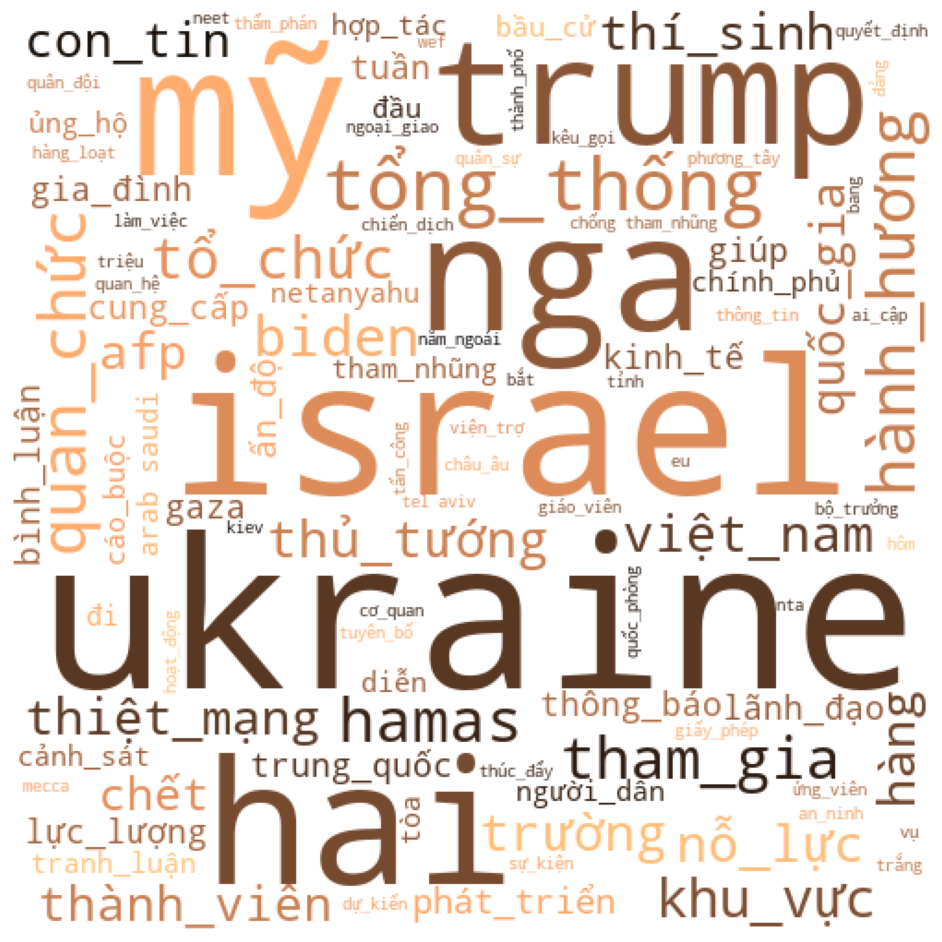

In [48]:
# corpus, stopwords = prepare_word_cloud(data, selected_columns=["article"], fixed_words=["giáo dục và đào tạo", "đại học quốc gia hà nội", "đại học quốc gia tphcm", "đhqg tphcm", "đại học qg tp hcm", "đại học quốc gia tphcm", "phổ thông năng khiếu"])
from backend.extractor.task.nlp_tasks import create_word_cloud

create_word_cloud(
    data, colormap="copper", selected_columns=["article"], regex_patterns=[], fixed_words=[], save=True, max_words=100,
)

# LLM Classify

In [ ]:
from backend.extractor.task.nlp_tasks import llm_extract_task

llm_extract_task(data, selected_columns=[])

{'mentions': '', 'tags': ''}

In [24]:
import asyncio
from time import time
from backend.llm.utils import parse_llm_response_data
from backend.logger import get_logger
from backend.llm.llm import LLM
from backend.extractor.task.llm_utils import llm_get_tags


logger = get_logger()
tasks = f"""{{
             "tags": "List 2 - 4 news categories that this article might belong to, return in list of strings"
             "mentions": "List all name of people, subjects, organizations, that the text mentions in keywords, return in list of strings",
             }}"""

def get_task_dict(task):
    task_dict = json.loads(task)
    res = {}
    for key in task_dict.keys():
        res[key] = ""
    return res


async def llm_extract_task(data, llm_task_format, columns=None, batch_size=12, delay=65):
    to_classify = []
    logger.info("Getting texts")
    if len(columns) == 0:
        selected_columns = list(data[0].keys())
    else: selected_columns = columns
    
    for row in data:
        text = "\n".join(value for key, value in row.items() if key in selected_columns)
        to_classify.append(text)

    def chunks(data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i : i + batch_size]

    batches = list(chunks(to_classify, batch_size))
    print(batches)
    responses = []
    for i, batch in enumerate(batches):
        logger.info(f"Processing batch number: {i + 1}")
        tasks = [llm_get_tags(text, llm_task_format) for text in batch]
        try:
            batch_responses = await asyncio.gather(*tasks, return_exceptions=True)
            for response in batch_responses:
                if isinstance(response, Exception):
                    print("Successful response")
                    responses.append(response)
                    print(response)
                else:
                    print(response)
                    responses.append(response)
        except Exception as e:
            print(f"Error processing batch number: {i + 1}, Error: {e}")
            # If the whole batch fails, add empty responses for the entire batch
            # responses.extend([get_task_dict(llm_task_format) for _ in batch])
        finally:
            if i < len(batches) - 1:
                await asyncio.sleep(delay)
    return responses

llm_responses = await llm_extract_task(data[0:40], tasks, columns=["article"], batch_size=10)

2024-06-24 13:48:03,291 - 943709598.py: llm_extract_task(): 25:	Getting texts
--------
2024-06-24 13:48:03,292 - 943709598.py: llm_extract_task(): 42:	Processing batch number: 1
--------


[['Vụ ngộ độc xảy ra ngày 18/6 khiến hơn 100 người phải nhập viện, song nhiều nạn nhân trong tình trạng nguy kịch đến mức các bác sĩ không thể cứu chữa. Muthuvel Stalin, thủ hiến bang Tamil Nadu, cho biết 37 người thiệt mạng vài giờ sau khi uống rượu pha cồn công nghiệp methanol. M.S. Prasanth, quan chức cấp cao tại quận Kallakurichi thuộc bang Tamil Nadu, ngày 22/6 thông báo 53 người chết trong vụ ngộ độc, 7 người liên quan đã bị bắt. Truyền thông Ấn Độ ngày 23/6 đưa tin 56 người đã tử vong, song giới chức nước này chưa bình luận về thông tin. Theo ủy viên hội đồng địa phương Palraj, những người lao động nghèo ở quận Kallakurichi thường mua những túi rượu giá 60 rupee (0,7 USD) để uống trước khi đi làm. Trong vụ ngộ độc ngày 18/6, một số người bị mù và được đưa tới bệnh viện, số khác chết trên phố. Ấn Độ ghi nhận hàng trăm người chết mỗi năm vì uống rượu giá rẻ mua từ các xưởng chưng cất lậu. Sự việc ở bang Tamil Nadu là một trong những vụ ngộ độc tồi tệ nhất tại Ấn Độ trong những năm

2024-06-24 13:49:11,222 - 943709598.py: llm_extract_task(): 42:	Processing batch number: 2
--------


{'tags': ['quân sự', 'chính trị', 'quan hệ quốc tế', 'Syria', 'Nga', 'Mỹ', 'không quân', 'máy bay không người lái', 'tiêm kích', 'UAV', 'MQ-9 Reaper', 'Su-35', 'F-15', 'Typhoon', 'A-10 Thunderbolt', 'Nhà nước Hồi giáo', 'IS', 'căn cứ quân sự', 'al-Tanf', 'al-Hasakah', 'Bashar al-Assad'], 'mentions': ['Yuri Popov', 'Trung tâm Hòa giải Các bên tham chiến tại Syria', 'Bộ Quốc phòng Nga', 'General Atomics', 'Cơ quan Nghiên cứu Quốc hội Mỹ', 'Lầu Năm Góc', 'Tổng thống Bashar al-Assad', 'Nhà nước Hồi giáo', 'IS']}
{'tags': ['chính trị', 'kinh tế', 'ngoại giao', 'hội nghị', 'thủ tướng', 'diễn đàn kinh tế thế giới', 'wef', 'trung quốc', 'việt nam', 'hợp tác', 'đầu tư', 'phát triển', 'biến đổi khí hậu', 'chuyển đổi số', 'chuyển đổi xanh', 'tăng trưởng', 'kinh tế thế giới', 'asean'], 'mentions': ['Phạm Minh Chính', 'Lý Cường', 'Andrzej Sebastian Duda', 'Phạm Sao Mai']}
{'tags': ['chính trị', 'tội phạm', 'hành hương', 'an ninh', 'thảm họa', 'Mecca', 'Arab Saudi', 'Ai Cập'], 'mentions': ['Thủ tướn

2024-06-24 13:50:19,409 - 943709598.py: llm_extract_task(): 42:	Processing batch number: 3
--------


{'tags': ['Tin tức', 'Quân sự', 'Nga'], 'mentions': ['Vũ Anh', 'Zvezda']}
{'tags': ['Quan hệ quốc tế', 'Chính trị', 'An ninh', 'Bán đảo Triều Tiên', 'Nga', 'Hàn Quốc', 'Triều Tiên', 'Hiệp ước', 'Quân sự'], 'mentions': ['Kim Hong-kyun', 'Georgy Zinoviev', 'Vladimir Putin', 'Kim Jong-un', 'Cho Tae-yul', 'Antony Blinken', 'Yoko Kamikawa', 'Chang Ho-jin', 'Ngọc Ánh', 'Reuters']}
{'tags': ['giáo dục', 'mẫu giáo', 'trường học', 'tư thục', 'công lập', 'tỷ lệ sinh', 'thiếu học sinh', 'đóng cửa', 'cạnh tranh', 'chính sách', 'kinh tế', 'xã hội'], 'mentions': ['Lin Xiao', 'Quảng Châu', 'Bộ Giáo dục', 'Liêu Ninh', 'Cát Lâm', 'Hắc Long Giang', 'Wang Haiying', 'Đại học Nam Kinh', 'Sun', 'Phật Sơn', 'Lei', 'Tây An', 'Qian You', 'Ninh Ba', 'Chiết Giang', 'Xu', 'Thượng Hải', 'Đức Trung', 'Sixth Tone']}
{'tags': ['Hành hương', 'Mecca', 'Hajj', 'Hồi giáo', 'Arab Saudi', 'Ai Cập', 'Tử vong', 'An toàn', 'Giấy phép', 'Du lịch', 'Thánh địa', 'Nhiệt độ', 'Xe buýt', 'Dịch vụ', 'Y tế'], 'mentions': ['AFP', 'Ara

2024-06-24 13:51:27,264 - 943709598.py: llm_extract_task(): 42:	Processing batch number: 4
--------


{'tags': ['chiến tranh', 'xung đột', 'Israel', 'Gaza', 'Hamas', 'Hezbollah', 'quân sự', 'chính trị', 'thương vong', 'con tin', 'ngoại giao', 'bạo lực', 'tấn công', 'oanh tạc', 'bệnh viện', 'cơ sở hạ tầng', 'dân thường', 'thỏa thuận ngừng bắn', 'trao đổi con tin', 'Lebanon', 'trung gian', 'quả cầu lửa', 'gara', 'khu dân cư', 'binh sĩ', 'chiến dịch', 'thể hiện ủng hộ', 'trục kháng chiến', 'chỉ huy cấp cao', 'thực thể trên không'], 'mentions': ['Fadel Naeem', 'Al-Ahli', 'Gaza City', 'Dải Gaza', 'Mahmud Basal', 'AFP', 'Israel', 'IDF', 'Hamas', 'Tel Aviv', 'Qatar', 'Lebanon', 'Hezbollah', 'Taleb Abdallah']}
{'tags': ['xả súng', 'bạo lực súng đạn', 'an ninh', 'tội phạm', 'thảm kịch', 'tin tức', 'sự kiện', 'Mỹ'], 'mentions': ['Mike Hagar', 'Giám đốc Cảnh sát bang Arkansas', 'Mad Butcher', 'Fordyce', 'Sarah Huckabee Sanders', 'Thống đốc Arkansas', 'David Rodriguez', 'Lưu trữ Bạo lực Súng đạn (GVA)', 'CNN', 'Reuters', 'Phạm Giang']}


In [25]:
def combine_res(data, responses, tasks):
    for record, response in zip(data, responses):
        if isinstance(response, dict):
            record.update(response)
        else: record.update(get_task_dict(tasks))

combine_res(data, llm_responses, tasks)

In [27]:
data

[{'title': 'Hơn 50 người Ấn Độ chết vì ngộ độc rượu',
  'description': 'Giới chức bang Tamil Nadu ở miền nam Ấn Độ thông báo 53 người chết vì uống rượu pha cồn công nghiệp methanol, một loại chất độc.',
  'article': 'Vụ ngộ độc xảy ra ngày 18/6 khiến hơn 100 người phải nhập viện, song nhiều nạn nhân trong tình trạng nguy kịch đến mức các bác sĩ không thể cứu chữa. Muthuvel Stalin, thủ hiến bang Tamil Nadu, cho biết 37 người thiệt mạng vài giờ sau khi uống rượu pha cồn công nghiệp methanol. M.S. Prasanth, quan chức cấp cao tại quận Kallakurichi thuộc bang Tamil Nadu, ngày 22/6 thông báo 53 người chết trong vụ ngộ độc, 7 người liên quan đã bị bắt. Truyền thông Ấn Độ ngày 23/6 đưa tin 56 người đã tử vong, song giới chức nước này chưa bình luận về thông tin. Theo ủy viên hội đồng địa phương Palraj, những người lao động nghèo ở quận Kallakurichi thường mua những túi rượu giá 60 rupee (0,7 USD) để uống trước khi đi làm. Trong vụ ngộ độc ngày 18/6, một số người bị mù và được đưa tới bệnh viện

In [76]:
responses

[]

In [54]:
[print(len(batch)) for batch in batches]

10
10
10
2


[None, None, None, None]

In [11]:
from backend.llm.llm import LLM

llm = LLM(
    system_instruction=(
        """Your job is to process the following text and extract relevant information for various tasks. 
    Output only the answers in requested format and the same language of the provided text. Output the answer solely based on the text you are provided"""
    ),
    response_mime_type="application/json",
)

text = """Kỳ thi tuyển sinh đại học y quốc gia (NEET-UG) là cánh cổng để theo đuổi ngành y tại Ấn Độ. NEET gồm 720 câu hỏi, chia đều 4 lĩnh vực vật lý, hóa học, động vật học và thực vật học. Các trường cao đẳng, đại học y sẽ xét tuyển dựa trên điểm số của thí sinh trong NEET. Kỳ thi do Cục khảo thí quốc gia Ấn Độ (NTA) tổ chức, ghi nhận hàng triệu thí sinh từ 17 tuổi dự thi mỗi năm. Năm nay, 2,4 triệu thí sinh tham gia NEET cạnh tranh 110.000 chỉ tiêu, trong số này, 55.000-60.000 là của các trường công. Các thí sinh đều hướng tới trường công vì lý do tài chính. Chương trình Cử nhân Y khoa và Cử nhân Phẫu thuật (MBBS) 5 năm ở trường công tốn từ 500.000 đến một triệu rupee (5.992-11.984 USD), trong khi đó, học phí trường tư có thể cao hơn 10 lần. NEET năm nay diễn ra ngày 5/5, kết quả công bố ngày 4/6. Kỳ thi gây chú ý vì hàng loạt cáo buộc, từ sai sót trong đề thi và chấm điểm sai cho đến lộ đề, gian lận. Hàng loạt thí sinh và phụ huynh đã yêu cầu NTA tổ chức lại kỳ thi, hàng chục đơn kiến nghị đã được nộp lên các tòa án ở Ấn Độ. NTA bác cáo buộc lộ đề. Bộ trưởng Giáo dục Ấn Độ Dharmendra Pradhan ngày 16/6 thừa nhận đã phát hiện "có sai phạm" tại một số trung tâm khảo thí. Ông Pradhan tuyên bố sẽ không bỏ qua cho bất cứ ai, kể cả quan chức NTA. Tòa án Tối cao Ấn Độ ngày 18/6 phán quyết "dù chỉ có 0,0001% sơ suất liên quan bất kỳ ai, NTA vẫn phải giải quyết thỏa đáng vấn đề". "NTA cần có lập trường rõ ràng. Nếu có sai phạm thì thừa nhận và thông báo giải quyết. Ít nhất việc này sẽ giúp tạo niềm tin vào NTA", thẩm phán S. V. Bhatti nói với đại diện NTA. Tại Ấn Độ, theo học ngành y hoặc kỹ sư là ước mơ của hàng chục triệu thí sinh mỗi năm. Đây là các nghề được tôn trọng và có thể có thu nhập ổn định, lâu dài ở quốc gia đang đối mặt khủng hoảng việc làm. Kết quả thi công bố ngày 4/6 cho thấy 67 thí sinh đạt điểm tối đa 720, số lượng nhiều chưa từng thấy. Kể từ năm 2016, khi NEET trở thành kỳ thi đầu vào chính thức của các trường cao đẳng, đại học y Ấn Độ, mỗi năm chỉ có từ một đến ba thí sinh đạt điểm tối đa, thậm chí không có ai. Số lượng thí sinh đạt điểm cao 650-680 năm nay cũng tăng đáng kể, khiến sự cạnh tranh vào trường y nhóm đầu của Ấn Độ càng gay gắt. Kết quả bất thường khiến các phụ huynh và thí sinh lo ngại. Họ cho rằng có bất thường trong khâu tổ chức thi và chấm điểm, kêu gọi giới chức Ấn Độ điều tra. NTA bác bỏ, cho rằng "tính toàn vẹn của cuộc thi không bị ảnh hưởng" và "số điểm cao nhiều hơn do lượng thí sinh tham gia thi tăng". NTA cũng thông báo 1.563 thí sinh được bù điểm do "bị thiệt về thời gian" ở các trung tâm khảo thí và một câu hỏi vật lý có hai đáp án đúng. Đáng chú ý, 50 trong số 67 thí sinh đạt điểm tối đa nhờ điểm bù này. Tòa án Tối cao Ấn Độ ngày 13/6 hủy quyết định bù điểm, sau khi một số sinh viên đệ đơn cho rằng quyết định của NTA là "tùy tiện và bất công". Tòa yêu cầu những thí sinh được bù điểm phải thi lại, dự kiến vào ngày 23/6 với kết quả được công bố một tuần sau đó. Tuy nhiên, những người biểu tình cho rằng phán quyết của Tòa án Tối cao chưa giải quyết được vấn đề họ nêu ra, như các cáo buộc lộ đề, gian lận và tham nhũng có hệ thống. Surbhi Sharma, 23 tuổi, năm nay tham gia NEET lần thứ 5 và được 650 điểm. Cô cho rằng lộ đề, tình trạng phổ biến ở Ấn Độ, là nguyên nhân dẫn đến sự biến động điểm số. Sharma lưu ý lượng thí sinh đạt điểm cao 650-680 tăng đáng kể, trong khi tỷ lệ đạt điểm khá 610-640 không tăng nhiều như vậy "NTA lý giải nhiều thí sinh đạt điểm cao vì đề thi năm nay dễ hơn. Nhưng nếu đúng như vậy thì tất cả đều phải có kết quả tốt hơn, thay vì chỉ một nhóm nhất định", Sharma lập luận. Tiến sĩ Vivek Pandey, nhà vận động hỗ trợ thí sinh khiếu nại, ủng hộ quan điểm của Sharma. Ông đã giúp 10 thí sinh đệ đơn lên Tòa án Tối cao, đề nghị được thi lại NEET vì cho rằng đề thi tại các trung tâm khảo thí ở Patna, thủ phủ bang Bihar, đã bị lộ. Cảnh sát Bihar mở cuộc điều tra ngay sau khi NEET diễn ra. Ngày 10/5, cảnh sát Bihar thông báo bắt 13 người, trong đó có 4 sinh viên, liên quan một vụ rò rỉ tài liệu. Ngày 15/6, cảnh sát tiếp tục gửi thông báo đến 9 thí sinh, đề nghị họ hợp tác điều tra. Sĩ quan Manavjit Singh Dhillon nói 13 nghi phạm bị cáo buộc tuồn đề thi cho 30 thí sinh một ngày trước khi NEET diễn ra, thu về hàng trăm nghìn rupee. Trong quá trình điều tra, cảnh sát còn thu thập được các tờ séc cùng tài liệu bị đốt cháy một phần. Họ đang đề nghị NTA cung cấp đề thi để đối chiếu. Ngoài nghi vấn lộ đề, NEET năm nay còn bị cáo buộc có gian lận. Cảnh sát đã bắt ba người ở Delhi và 6 người ở bang Rajasthan nghi thi hộ NEET. Tại bang Gujarat, cảnh sát bắt 5 người nghi tham gia kế hoạch gian lận ở trung tâm khảo thí thành phố Godhra. Phe đối lập chỉ trích liên minh cầm quyền do đảng Bharatiya Janata (BJP) dẫn dắt đã "phản bội giấc mơ" của hàng triệu thí sinh. Lãnh đạo đảng đối lập Quốc đại Ấn Độ (INC) Mallikarjun Kharge đã đặt câu hỏi về sự im lặng của Thủ tướng Narendra Modi, cáo buộc chính phủ của ông "che đậy những sai sót của NEET". INC kêu gọi Tòa án Tối cao điều tra cáo buộc có bất thường trong NEET năm nay. Trong khi đó, Tòa án Tối cao Ấn Độ đã thụ lý và dự kiến bắt đầu giải quyết hàng loạt khiếu nại liên quan kết quả NEET, bao gồm hủy kết quả thi, từ ngày 8/7. "Hãy tưởng tượng một người gian lận để trở thành bác sĩ! Người đó sẽ có hại cho xã hội", thẩm phán Bhatti cảnh báo về hậu quả tiềm ẩn. Đại diện NTA kêu gọi tòa không đưa ra phán quyết trước khi cơ quan này có phản hồi về các khiếu nại. Như Tâm (Theo BBC, Indian Express)',"""

prompt = f"""Extract the required information from the following text and output in the following JSON format:
             {tasks}
             ---
             - Follow the instructions to extract the information as requested
             - The value of the JSON should be kept in the language of the text, keep the key of the output JSON as requested.
             - Output only the JSON object.
             ---
             Text: {text}"""

response = await llm_get_tags(text, tasks)

In [12]:
response

{'mentions': '["NEET-UG", "Ấn Độ", "NTA", "Dharmendra Pradhan", "S. V. Bhatti", "Narendra Modi", "Mallikarjun Kharge", "INC", "Surbhi Sharma", "Vivek Pandey", "Bihar", "Manavjit Singh Dhillon", "BJP", "Godhra", "Rajasthan", "Delhi"]',
 'tags': '["Giáo dục", "Kỳ thi", "Ấn Độ", "Y tế", "Lộ đề", "Gian lận", "Tòa án", "Điều tra", "Bất thường", "Cáo buộc", "Phản đối", "Chính trị"]'}